In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import integrate, optimize, stats

In [2]:
np.random.seed(3125)
torch.manual_seed(3125)

In [3]:
A = 1.0  # Parameter for bimodal 
batch_size = 4000
num_samples = batch_size
device = "cpu"

# Define PDFs
def bimodal_pdf_unnorm(x, A=1.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return torch.exp(-1/A * (-x**2/2 + x**4/4))

def normal_pdf(x, sigma=1.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-x**2/(2*sigma**2))

# Calculate normalization constant Z numerically
def compute_Z(A):
    integrand = lambda x: np.exp(-1/A * (-x**2/2 + x**4/4))
    result, _ = integrate.quad(integrand, -10, 10) 
    return result

Z = compute_Z(A)
print(f"Normalization constant Z = {Z:.6f}")

def calculate_M(sigma, A, Z):
    x_vals = np.linspace(-10, 10, 10000)  
    bimodal_unnorm = np.exp(-1/A * (-x_vals**2/2 + x_vals**4/4))
    bimodal = bimodal_unnorm / Z
    normal = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_vals**2/(2*sigma**2))
    
    # Handle potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = np.where(normal > 1e-10, bimodal / normal, 0)
    
    return np.max(ratios) * 1.01  # Add 1% safety margin

def find_optimal_sigma(A, Z):

    def objective(sigma):
            return calculate_M(sigma[0], A, Z)
    
    bounds = [(0.1, 5.0)] 
    initial_guess = [1.0]
    
    result = optimize.minimize(
        objective, 
        initial_guess, 
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_sigma = result.x[0]
    return optimal_sigma

Normalization constant Z = 3.905137


In [4]:
# Find optimal sigma
sigma = find_optimal_sigma(A, Z)
print(f"Optimal sigma for A={A}: {sigma:.6f}")

Optimal sigma for A=1.0: 1.271737


In [5]:
# Calculate M using the optimal sigma
M = calculate_M(sigma, A, Z)
print(f"Optimal M with sigma={sigma:.6f}: {M:.6f}")
print(f"Acceptance rate (efficiency): {100/M:.2f}%")

Optimal M with sigma=1.271737: 1.586783
Acceptance rate (efficiency): 63.02%


In [6]:
A_values = np.linspace(0.5, 20.0, 20)
sigma_values = []
M_values = []
efficiency_values = []

for a_val in A_values:
    z_val = compute_Z(a_val)
    sigma_val = find_optimal_sigma(a_val, z_val)
    m_val = calculate_M(sigma_val, a_val, z_val)
    
    sigma_values.append(sigma_val)
    M_values.append(m_val)
    efficiency_values.append(100/m_val)
    
    print(f"A={a_val:.2f}, optimal σ={sigma_val:.4f}, M={m_val:.4f}, efficiency={100/m_val:.2f}%")

A=0.50, optimal σ=1.1691, M=1.8057, efficiency=55.38%
A=1.53, optimal σ=1.3531, M=1.5054, efficiency=66.43%
A=2.55, optimal σ=1.4751, M=1.4373, efficiency=69.57%
A=3.58, optimal σ=1.5672, M=1.4050, efficiency=71.18%
A=4.61, optimal σ=1.6443, M=1.3855, efficiency=72.18%
A=5.63, optimal σ=1.7105, M=1.3721, efficiency=72.88%
A=6.66, optimal σ=1.7692, M=1.3624, efficiency=73.40%
A=7.68, optimal σ=1.8212, M=1.3548, efficiency=73.81%
A=8.71, optimal σ=1.8692, M=1.3487, efficiency=74.14%
A=9.74, optimal σ=1.9132, M=1.3438, efficiency=74.42%


/tmp/ipykernel_324521/2142973729.py:35: RuntimeWarning: overflow encountered in divide
  ratios = np.where(normal > 1e-10, bimodal / normal, 0)


A=10.76, optimal σ=1.9540, M=1.3396, efficiency=74.65%
A=11.79, optimal σ=1.9927, M=1.3360, efficiency=74.85%
A=12.82, optimal σ=2.0288, M=1.3328, efficiency=75.03%
A=13.84, optimal σ=2.0629, M=1.3301, efficiency=75.18%
A=14.87, optimal σ=2.0952, M=1.3277, efficiency=75.32%
A=15.89, optimal σ=2.1252, M=1.3255, efficiency=75.44%
A=16.92, optimal σ=2.1552, M=1.3235, efficiency=75.56%
A=17.95, optimal σ=2.1832, M=1.3218, efficiency=75.66%
A=18.97, optimal σ=2.2099, M=1.3201, efficiency=75.75%
A=20.00, optimal σ=2.2359, M=1.3186, efficiency=75.84%


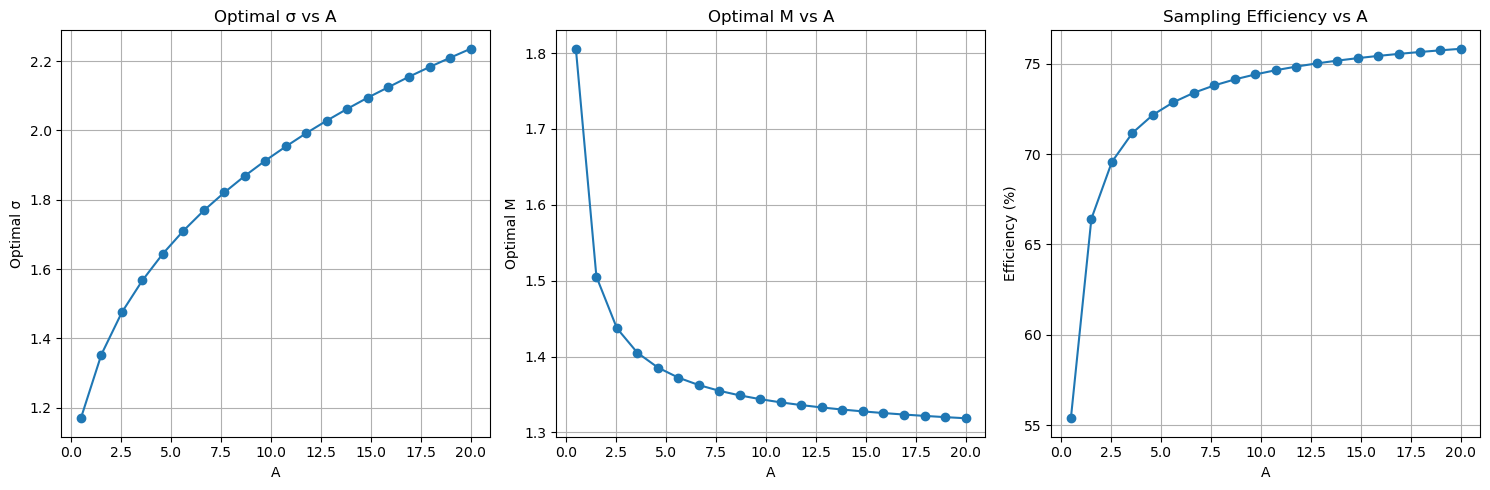

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(A_values, sigma_values, 'o-')
plt.title('Optimal σ vs A')
plt.xlabel('A')
plt.ylabel('Optimal σ')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(A_values, M_values, 'o-')
plt.title('Optimal M vs A')
plt.xlabel('A')
plt.ylabel('Optimal M')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(A_values, efficiency_values, 'o-')
plt.title('Sampling Efficiency vs A')
plt.xlabel('A')
plt.ylabel('Efficiency (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig('a_sigma_m_relationships.png', dpi=300)
plt.show()

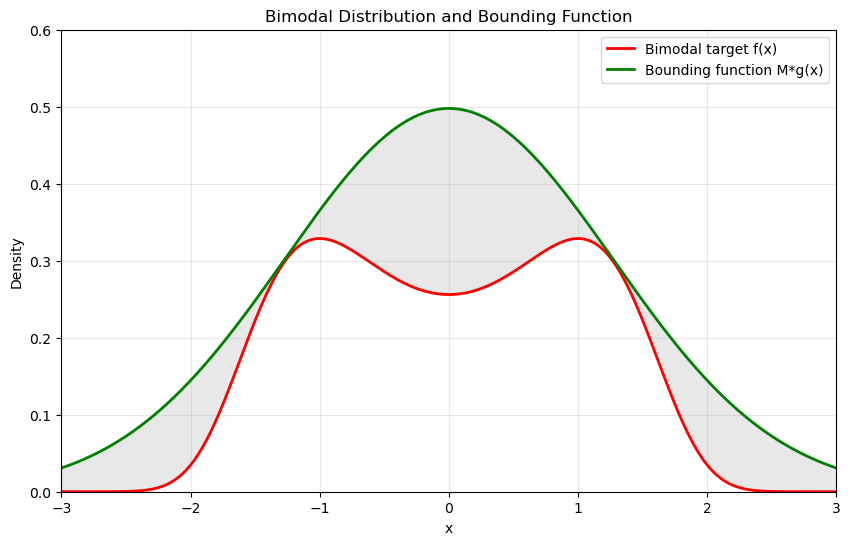

In [8]:
x_vals = np.linspace(-3, 3, 1000)

bimodal_vals = bimodal_pdf_unnorm(x_vals) / Z

bounding_function = M * normal_pdf(x_vals, sigma)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, bimodal_vals, 'r-', linewidth=2, label='Bimodal target f(x)')
plt.plot(x_vals, bounding_function, 'g-', linewidth=2, label='Bounding function M*g(x)')
plt.fill_between(x_vals, bimodal_vals, bounding_function, where=(bounding_function > bimodal_vals),
                color='lightgray', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-3, 3)
plt.ylim(0, 0.6)
plt.title('Bimodal Distribution and Bounding Function')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

In [9]:
# Initialize storage for accepted samples
accepted_samples = torch.zeros(num_samples, 1).to(device)
accepted_count = 0
total_iterations = 0
max_iterations = 1000000  # Prevent infinite loops

# Start timing
start_time = time.time()

# Main acceptance-rejection loop
while accepted_count < num_samples and total_iterations < max_iterations:
    # Generate proposal samples from normal distribution
    proposal_batch_size = min(batch_size, num_samples - accepted_count)
    normal_samples = np.random.normal(0, sigma, size=proposal_batch_size).astype(np.float32)
    proposal_samples = torch.tensor(normal_samples).unsqueeze(1).to(device)
    
    # Generate uniform samples for acceptance test
    uni_acceptance = np.random.uniform(low=0, high=1, size=proposal_batch_size).astype(np.float32)
    uni_acceptance = torch.tensor(uni_acceptance).unsqueeze(1).to(device)
    
    # Compute bimodal density of proposal
    bimodal_density = bimodal_pdf_unnorm(proposal_samples, A=A) / Z
    
    # Compute proposal density
    prop_density = normal_pdf(proposal_samples, sigma=sigma)
    
    # Compute acceptance probability
    acceptance_ratio = bimodal_density / (M * prop_density)
    
    # Accept samples where uni_acceptance <= acceptance_ratio
    accept_mask = (uni_acceptance <= acceptance_ratio).squeeze()
    
    if accept_mask.sum() > 0:
        num_accepted_batch = min(accept_mask.sum().item(), num_samples - accepted_count)
        accepted_samples[accepted_count:accepted_count + num_accepted_batch] = \
            proposal_samples[accept_mask][:num_accepted_batch]
        accepted_count += num_accepted_batch
    
    total_iterations += proposal_batch_size
    
    if total_iterations % 10000 == 0:
        print(f'Iterations: {total_iterations}, Accepted: {accepted_count}/{num_samples}, ' 
              f'Efficiency: {100 * accepted_count / total_iterations:.2f}%')

elapsed_time = time.time() - start_time
efficiency = 100 * accepted_count / total_iterations

print(f"Bimodal sampling completed in {elapsed_time:.2f} seconds.")
print(f"Generated {accepted_count} samples from {total_iterations} proposal samples.")
print(f"Acceptance efficiency: {efficiency:.2f}%")
print(f"Theoretical acceptance rate: {100/M:.2f}%")

bimodal_samples = accepted_samples.cpu().numpy()
bimodal_samples_flat = bimodal_samples.flatten()

Bimodal sampling completed in 0.02 seconds.
Generated 4000 samples from 6374 proposal samples.
Acceptance efficiency: 62.75%
Theoretical acceptance rate: 63.02%


Text(0, 0.5, 'Density')

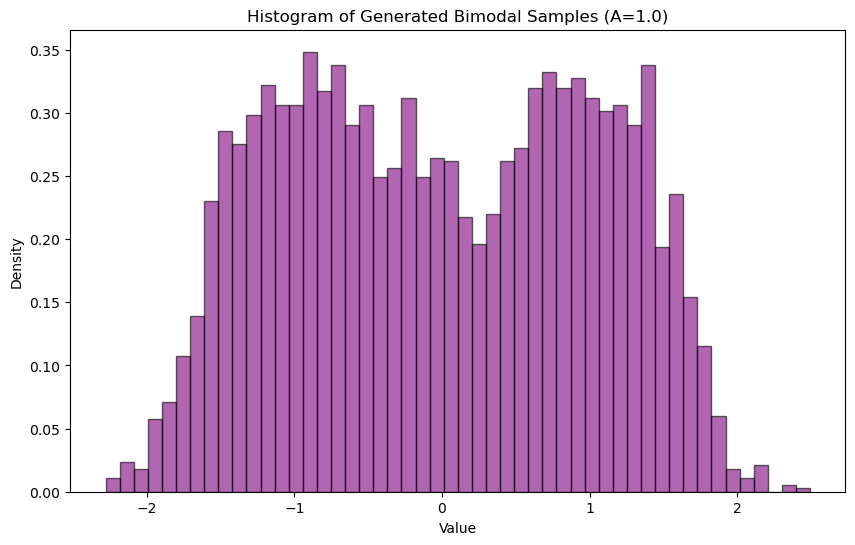

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(bimodal_samples_flat, bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
plt.title(f'Histogram of Generated Bimodal Samples (A={A})')
plt.xlabel('Value')
plt.ylabel('Density')

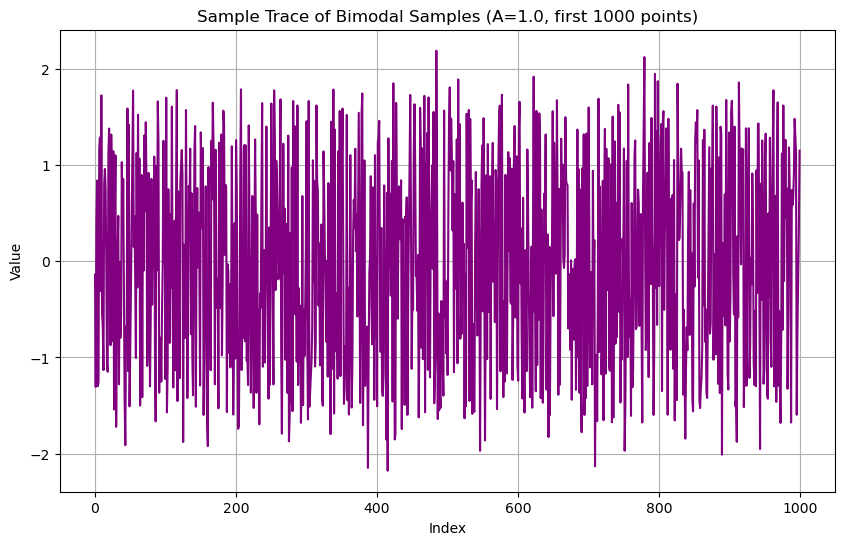

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(bimodal_samples_flat[:min(1000, len(bimodal_samples_flat))], color='purple')
plt.title(f'Sample Trace of Bimodal Samples (A={A}, first 1000 points)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

/opt/spack/opt/spack/linux-rhel8-icelake/gcc-12.2.0/anaconda3-2023.09-0-cnhkdqo23hjp6vajx75rg2skgd46qyjv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


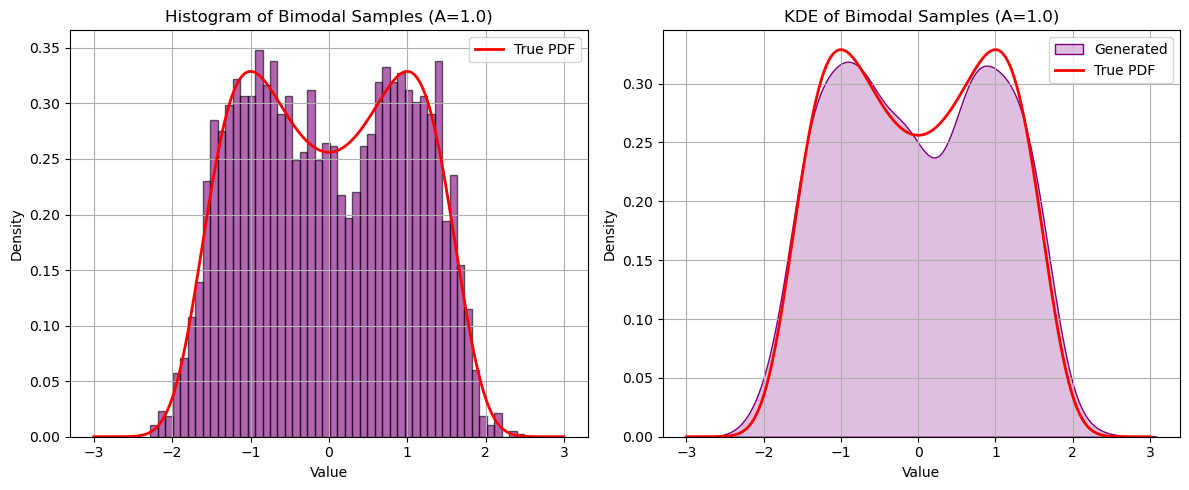

Bimodal Distribution Statistics (A=1.0):
Mean: -0.0076
Variance: 1.0690
Skewness: 0.0135
Kurtosis: -1.1618


In [12]:
# Plot histogram and KDE side by side
plt.figure(figsize=(12, 5))
# Subplot 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(bimodal_samples_flat, bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
plt.plot(x_vals, bimodal_vals, 'r-', linewidth=2, label='True PDF')
plt.title(f'Histogram of Bimodal Samples (A={A})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Subplot 2: KDE with true PDF
plt.subplot(1, 2, 2)
sns.kdeplot(bimodal_samples_flat, color='purple', fill=True, label='Generated')
plt.plot(x_vals, bimodal_vals, 'r-', linewidth=2, label='True PDF')
plt.title(f'KDE of Bimodal Samples (A={A})')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print stats
print(f"Bimodal Distribution Statistics (A={A}):")
print(f"Mean: {np.mean(bimodal_samples_flat):.4f}")
print(f"Variance: {np.var(bimodal_samples_flat):.4f}")
print(f"Skewness: {stats.skew(bimodal_samples_flat):.4f}")
print(f"Kurtosis: {stats.kurtosis(bimodal_samples_flat):.4f}")

A=0.10, optimal σ=1.0451, M=3.4295, efficiency=29.16%
A=12.92, optimal σ=2.0316, M=1.3326, efficiency=75.04%
A=25.74, optimal σ=2.3656, M=1.3121, efficiency=76.21%


/tmp/ipykernel_324521/2142973729.py:35: RuntimeWarning: overflow encountered in divide
  ratios = np.where(normal > 1e-10, bimodal / normal, 0)


A=38.55, optimal σ=2.5939, M=1.3035, efficiency=76.72%
A=51.37, optimal σ=2.7720, M=1.2985, efficiency=77.01%
A=64.19, optimal σ=2.9200, M=1.2951, efficiency=77.22%
A=77.01, optimal σ=3.0475, M=1.2926, efficiency=77.36%
A=89.83, optimal σ=3.1613, M=1.2907, efficiency=77.48%
A=102.64, optimal σ=3.2626, M=1.2892, efficiency=77.57%
A=115.46, optimal σ=3.3553, M=1.2879, efficiency=77.65%
A=128.28, optimal σ=3.4407, M=1.2868, efficiency=77.71%
A=141.10, optimal σ=3.5194, M=1.2859, efficiency=77.76%
A=153.92, optimal σ=3.5936, M=1.2851, efficiency=77.81%
A=166.73, optimal σ=3.6633, M=1.2845, efficiency=77.85%
A=179.55, optimal σ=3.7294, M=1.2838, efficiency=77.89%
A=192.37, optimal σ=3.7915, M=1.2833, efficiency=77.93%
A=205.19, optimal σ=3.8514, M=1.2828, efficiency=77.96%
A=218.01, optimal σ=3.9078, M=1.2823, efficiency=77.98%
A=230.82, optimal σ=3.9625, M=1.2819, efficiency=78.01%
A=243.64, optimal σ=4.0148, M=1.2815, efficiency=78.03%
A=256.46, optimal σ=4.0651, M=1.2812, efficiency=78.0

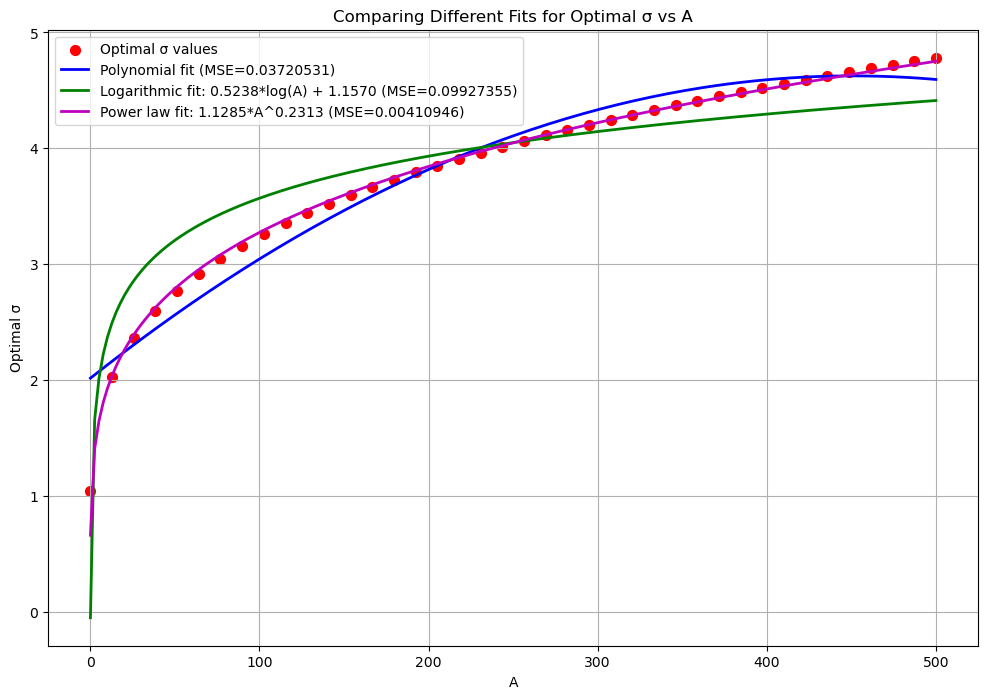


Predicted optimal sigma values using the best fit function:
A=0.5, predicted σ=0.961298
A=11.6, predicted σ=1.987527
A=22.6, predicted σ=2.321372
A=33.7, predicted σ=2.545258
A=44.7, predicted σ=2.718046
A=55.8, predicted σ=2.860536
A=66.8, predicted σ=2.982717
A=77.9, predicted σ=3.090221
A=88.9, predicted σ=3.186563
A=100.0, predicted σ=3.274097


In [37]:
A_values = np.linspace(.1, 500.0, 40)
sigma_values = []
M_values = []
efficiency_values = []
for a_val in A_values:
    z_val = compute_Z(a_val)
    sigma_val = find_optimal_sigma(a_val, z_val)
    m_val = calculate_M(sigma_val, a_val, z_val)
    
    sigma_values.append(sigma_val)
    M_values.append(m_val)
    efficiency_values.append(100/m_val)
    
    print(f"A={a_val:.2f}, optimal σ={sigma_val:.4f}, M={m_val:.4f}, efficiency={100/m_val:.2f}%")

A_values = np.array(A_values)
sigma_values = np.array(sigma_values)
degree = 2
poly_coeffs = np.polyfit(A_values, sigma_values, degree)

def poly_function(A):
    result = 0
    for i, coeff in enumerate(reversed(poly_coeffs)):
        result += coeff * (A ** i)
    return result

def log_func(A, a, b):
    return a * np.log(A) + b

def log_fit_error(params, x, y):
    a, b = params
    y_pred = log_func(x, a, b)
    return np.sum((y_pred - y)**2)

initial_guess = [0.5, 0.5]
result = optimize.minimize(log_fit_error, initial_guess, args=(A_values, sigma_values))
log_params = result.x
print(f"Logarithmic fit parameters: a={log_params[0]:.6f}, b={log_params[1]:.6f}")

def log_function(A):
    a, b = log_params
    return a * np.log(A) + b

def power_func(A, c, d):
    return c * (A**d)

def power_fit_error(params, x, y):
    c, d = params
    y_pred = power_func(x, c, d)
    return np.sum((y_pred - y)**2)

initial_guess = [1.0, 0.3]  
result = optimize.minimize(power_fit_error, initial_guess, args=(A_values, sigma_values))
power_params = result.x
print(f"Power law fit parameters: c={power_params[0]:.6f}, d={power_params[1]:.6f}")

def power_function(A):
    c, d = power_params
    return c * (A**d)

A_test = np.linspace(0.1, 500.0, 200)
sigma_poly = np.array([poly_function(a) for a in A_test])
sigma_log = np.array([log_function(a) for a in A_test])
sigma_power = np.array([power_function(a) for a in A_test])

mse_poly = np.mean((np.array([poly_function(a) for a in A_values]) - sigma_values)**2)
mse_log = np.mean((np.array([log_function(a) for a in A_values]) - sigma_values)**2)
mse_power = np.mean((np.array([power_function(a) for a in A_values]) - sigma_values)**2)

print(f"Mean Squared Error - Polynomial: {mse_poly:.8f}")
print(f"Mean Squared Error - Logarithmic: {mse_log:.8f}")
print(f"Mean Squared Error - Power Law: {mse_power:.8f}")

plt.figure(figsize=(12, 8))
plt.scatter(A_values, sigma_values, color='red', s=50, label='Optimal σ values')
plt.plot(A_test, sigma_poly, 'b-', linewidth=2, label=f'Polynomial fit (MSE={mse_poly:.8f})')
plt.plot(A_test, sigma_log, 'g-', linewidth=2, label=f'Logarithmic fit: {log_params[0]:.4f}*log(A) + {log_params[1]:.4f} (MSE={mse_log:.8f})')
plt.plot(A_test, sigma_power, 'm-', linewidth=2, label=f'Power law fit: {power_params[0]:.4f}*A^{power_params[1]:.4f} (MSE={mse_power:.8f})')
plt.title('Comparing Different Fits for Optimal σ vs A')
plt.xlabel('A')
plt.ylabel('Optimal σ')
plt.legend()
plt.grid(True)
plt.savefig('sigma_function_comparison.png', dpi=300)
plt.show()

def optimal_sigma_new(A):
    mse_values = [mse_poly, mse_log, mse_power]
    best_model_index = np.argmin(mse_values)
    
    if best_model_index == 0:
        return poly_function(A)
    elif best_model_index == 1:
        return log_function(A)
    else:
        return power_function(A)

print("\nPredicted optimal sigma values using the best fit function:")
for a_val in np.linspace(0.5, 100.0, 10):
    print(f"A={a_val:.1f}, predicted σ={optimal_sigma_new(a_val):.6f}")